<a href="https://colab.research.google.com/github/ahn283/finance/blob/main/tensorflow_weather_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 학습 코드를 실행하기 전에 <b>[런타임]</b> - <b>[런타임 유형 변경]</b>에서 하드웨어 가속기를 <b>[GPU]</b>로 설정한다.

### <b>데이터 세트 다운로드</b>

* 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

In [1]:
!git clone https://github.com/ndb796/weather_dataset
%cd weather_dataset

Cloning into 'weather_dataset'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1117 (delta 0), reused 3 (delta 0), pack-reused 1111
Receiving objects: 100% (1117/1117), 85.23 MiB | 30.99 MiB/s, done.
/content/weather_dataset


### <b>라이브러리 불러오기(Load Libraries)</b>

* 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

### <b>데이터 세트 불러오기(Load Dataset)</b>

1. <b>데이터 증진(data augmentation)</b>을 명시하여 초기화할 수 있다.
  * 이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 것인지 명시한다.
2. 이후에 <b>flow()</b>를 이용하여 실질적으로 데이터를 불러올 수 있다.
  * 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시한다.
  * <b>next() 함수</b>를 이용하여 numpy array 형태로 데이터를 배치 단위로 얻을 수 있다.
* <b>Reference</b>: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset

In [3]:
train_generator = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    validation_split=0.2
)
test_generator = ImageDataGenerator(rescale=1/255.)

train_flow = train_generator.flow_from_directory(
    directory='train/',
    shuffle=True,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    subset='training'
)
val_flow = train_generator.flow_from_directory(
    directory='train/',
    shuffle=True,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64,
    subset='validation'
)
test_flow = train_generator.flow_from_directory(
    directory='test/',
    shuffle=False,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=64
)

Found 676 images belonging to 4 classes.
Found 168 images belonging to 4 classes.
Found 281 images belonging to 4 classes.


### <b>데이터 시각화(Data Visualization)</b>

['Shine', 'Rain', 'Rain', 'Sunrise']


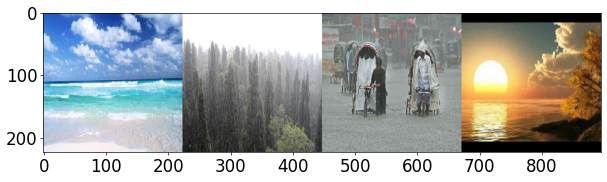

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

class_names = {
    0: 'Cloudy',
    1: 'Rain',
    2: 'Shine',
    3: 'Sunrise'
}

images, targets = next(train_flow)

print([class_names[x] for x in np.argmax(targets[:4], axis=1)])
plt.imshow(np.concatenate((images[0], images[1], images[2], images[3]), axis=1))
plt.show()

### <b>딥러닝 모델 학습(Training)</b>

* 사전 학습된(pre-trained) 모델(model)을 이용하여 가지고 있는 데이터 세트에 대한 학습이 가능하다.
  * <b>include_top</b>: 네트워크 뒤에 FC (fully-connected) 레이어를 포함하는지 여부
  * <b>weights</b>: None 혹은 "imagenet"
  * 네트워크의 마지막에 FC 레이어를 적용하여 클래스 개수를 일치시킨다.

In [5]:
model = Sequential()
pretrained_model = InceptionV3(
    input_shape = (224, 224, 3),
    include_top=False,
    weights='imagenet'
)
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(4, activation='softmax'))
model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 4)                 204804    
                                                                 
Total params: 22,007,588
Trainable params: 21,973,156
Non-trainable params: 34,432
_________________________________________________________________


In [6]:
learning_rate = 0.001

# compile
model.compile(
    optimizer=optimizers.SGD(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# fit datasets
history = model.fit(
    train_flow,
    epochs=15,
    validation_data=val_flow
)

Epoch 1/15
11/11 [==============================] - 40s 1s/step - loss: 1.2316 - accuracy: 0.4645 - val_loss: 1.4367 - val_accuracy: 0.4345
Epoch 2/15
11/11 [==============================] - 7s 671ms/step - loss: 0.7839 - accuracy: 0.7293 - val_loss: 1.1047 - val_accuracy: 0.5952
Epoch 3/15
11/11 [==============================] - 7s 652ms/step - loss: 0.5288 - accuracy: 0.8506 - val_loss: 1.0947 - val_accuracy: 0.5417
Epoch 4/15
11/11 [==============================] - 7s 668ms/step - loss: 0.3660 - accuracy: 0.9246 - val_loss: 0.9179 - val_accuracy: 0.6488
Epoch 5/15
11/11 [==============================] - 7s 676ms/step - loss: 0.2796 - accuracy: 0.9453 - val_loss: 0.7386 - val_accuracy: 0.6964
Epoch 6/15
11/11 [==============================] - 7s 625ms/step - loss: 0.2642 - accuracy: 0.9379 - val_loss: 0.6818 - val_accuracy: 0.7262
Epoch 7/15
11/11 [==============================] - 7s 653ms/step - loss: 0.1947 - accuracy: 0.9615 - val_loss: 0.5620 - val_accuracy: 0.7798
Epoch 8/

### <b>학습 결과 확인하기</b>

* 학습 결과를 시각화하여 정상적으로 모델이 학습되었는지 확인한다.

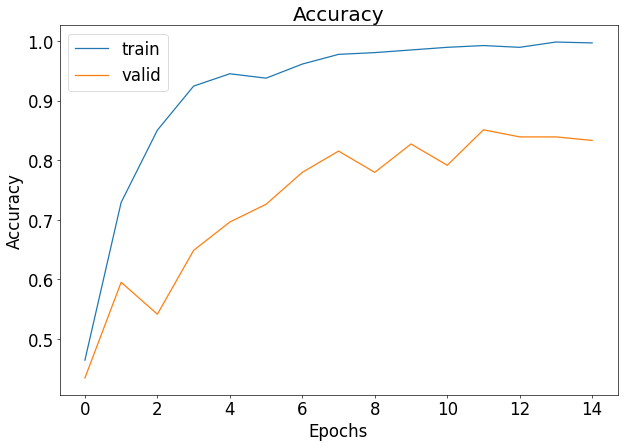

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy')
plt.legend(['train', 'valid'])
plt.show()

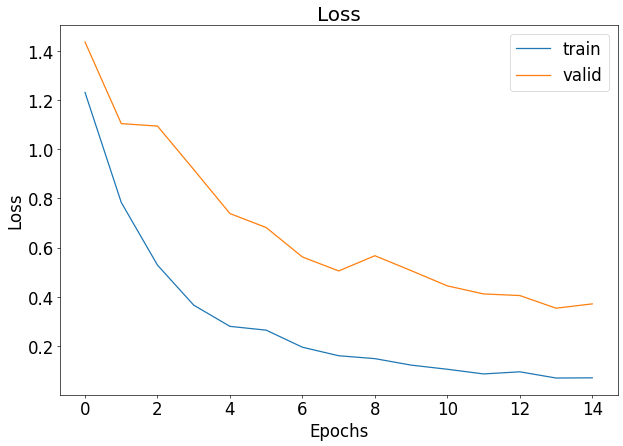

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.show()

In [11]:
# test model
test_history = model.evaluate(test_flow)
test_loss, test_accuracy = test_history

print(f'Test loss: {test_loss:.8f}')
print(f'Test accuracy: {test_accuracy * 100.:.2f}%')

5/5 [==============================] - 1s 169ms/step - loss: 0.2735 - accuracy: 0.9110
Test loss: 0.27345628
Test accuracy: 91.10%
